In [464]:
import pandas as pd
import time
import json
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import write_dot, graphviz_layout

In [142]:
df = pd.read_csv('/Users/emilydennis/Desktop/lightsheet/labels_updated/PRA_labels_with-graph-order_children_parents.csv')
df.head(2)

,id,name,parent_id,graph_order,children,has_children,parent_ids
0,0,NaN,root,0,"[443,444,445,446,448,450,451,452]",1,root
1,35,brainstem,449,2,"[39, 40, 41, 577, 595, 189, 190, 265, 266, 267...",1,0


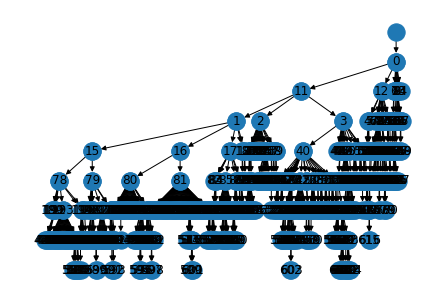

In [143]:
g = nx.DiGraph()

for index, row in df.iterrows():
    g.add_node(row.id,name=row.name)
    g.add_edge(row.parent_id,row.id)

labels = nx.get_node_attributes(g, 'name')
pos =graphviz_layout(g, prog='dot')
nx.draw(g, pos, with_labels=True,labels=labels, arrows=True)

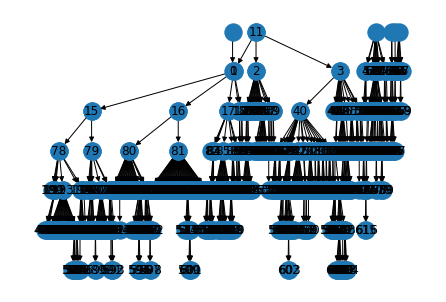

1

In [152]:
# useful nx functions
nx.all_pairs_lowest_common_ancestor(g)

<generator object all_pairs_lowest_common_ancestor.<locals>._compute_dag_lca_from_tree_values at 0x7f98c4b7ae58>

In [154]:
for x in nx.node_boundary(g,['449']):
    print(x)

35
36
37


In [438]:
def get_subgraph_by_val(g,num):
    vals=[]
    for x in nx.neighbors(g,str(num)):
        vals.append(x)
    for x in vals:
        print(x)
        if str(x) in g:
            print('x in g')
            for subx in nx.neighbors(g,str(x)):
                print('subx is {}'.format(subx))
                vals.append(subx)
    sg = g.copy()
    print('not in')
    novals=[]
    for n in sg:
        if n not in vals:
            if n == num:
                print('n is num!!!!!!!')
            else:
                print(n)
                novals.append(n)
    sg.remove_nodes_from(novals)
    return sg

In [561]:
sg = g.copy()
num=449
val = list(nx.ancestors(g,num))

for x in val:
    print('x is {}'.format(x))
    for xx in list(nx.descendants(g,x)):
        print(xx)
        val.append(xx)


x is 0
448
449
450
451
452
443
444
445
446
x is 448
x is 449
x is 450
x is 451
x is 452
x is 443
x is 444
x is 445
x is 446


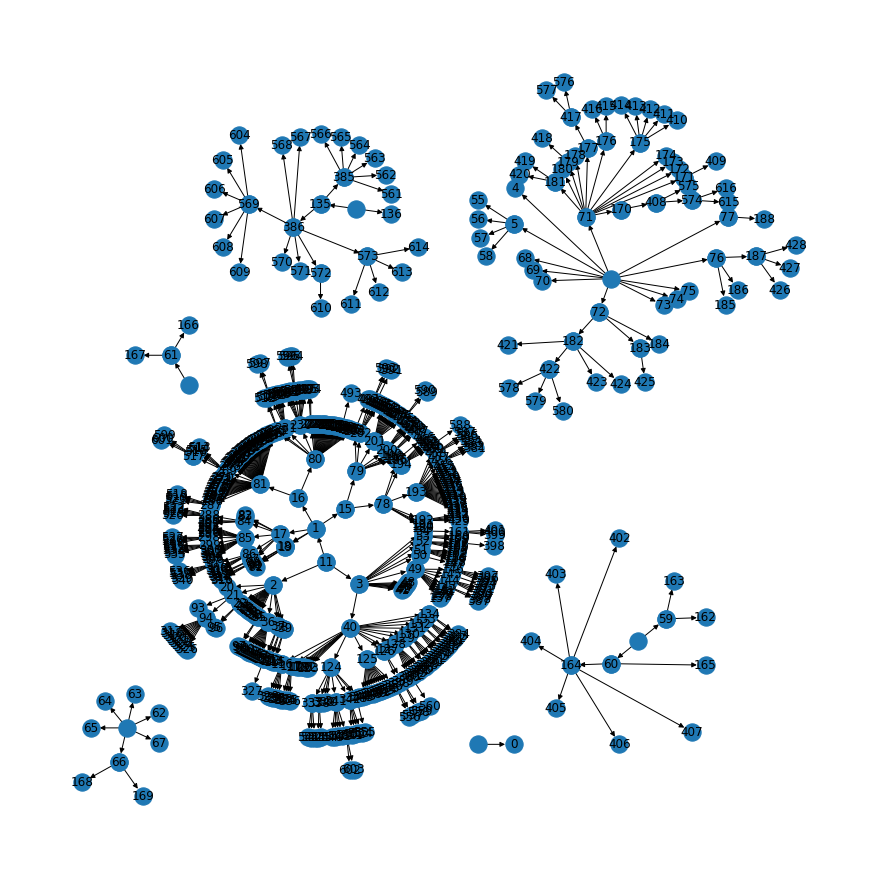

In [547]:
plt.figure(figsize=(12, 12))
labels = nx.get_node_attributes(sg, 'name')

pos = graphviz_layout(sg, prog="twopi", args="")
nx.draw(sg, pos, labels=labels,arrows=True)


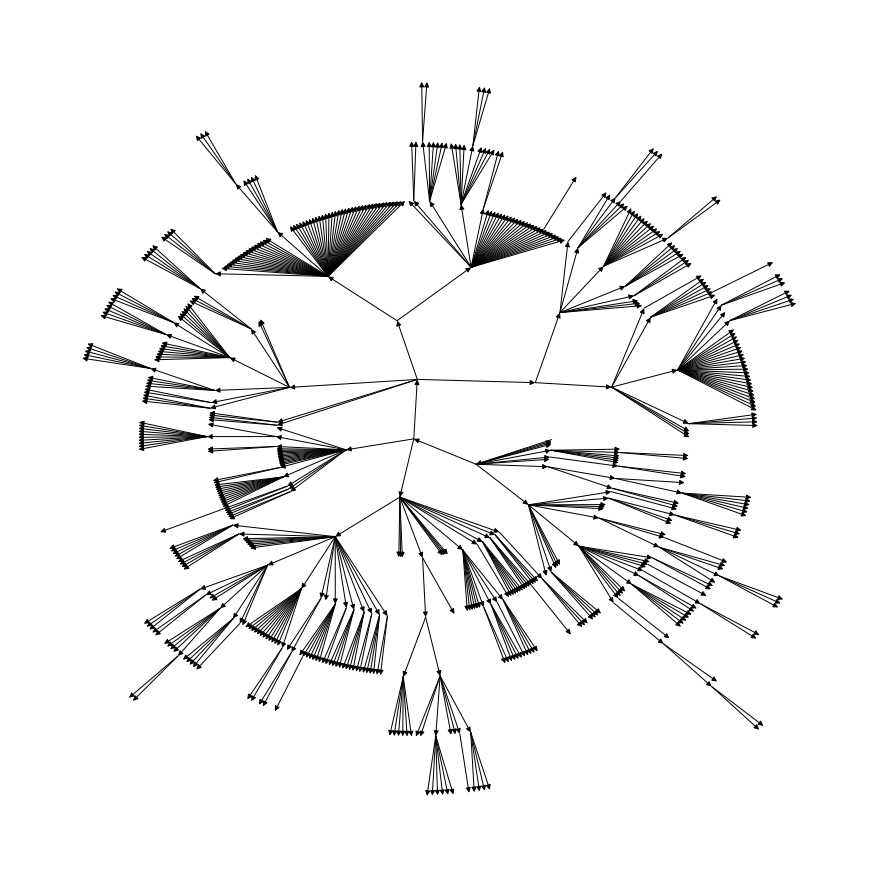

In [399]:
plt.figure(figsize=(12, 12))
pos = graphviz_layout(g, prog="twopi", args="")
nx.draw(g, pos, arrows=True,node_size=0)

### reading about networkx
https://networkx.org/documentation/stable/reference/algorithms/dag.html 
https://networkx.org/documentation/stable/reference/algorithms/traversal.html

In [100]:
nx.write_gexf(g,'/Users/emilydennis/Desktop/lightsheet/pra_ingexf.gexf')

In [114]:
x=g.subgraph(nx.descendants(g,'449'))

In [134]:
nx.is_branching(g) and nx.is_forest(g)

True